In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Env

In [0]:
ROOT_PATH = 'gdrive/My Drive/HSE/loops'

In [3]:
pip install https://bitbucket.org/mirnylab/mirnylib/get/tip.tar.gz

     \ 102kB 674kB/s
     |████████████████████████████████| 2.2MB 28.5MB/s 
  Created wheel for mirnylib: filename=mirnylib-0.0.0-cp36-cp36m-linux_x86_64.whl size=1014920 sha256=2df62ea24e27efca4eba9a9465df2e4114c4e138cbb41288cd87478792313c5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ek6527_n/wheels/51/dd/9c/8403bb71e9b379ab467b193aa2c781a19eb7f4dec64b4ec609
Successfully built mirnylib


In [0]:
import numpy as np
import pandas as pd
import random
import os
import sys
import matplotlib.pyplot as plt
import cv2

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.metrics import binary_crossentropy

from sklearn.model_selection import train_test_split

sys.path.insert(0, ROOT_PATH)
# data preparation for dicty
from prepare_data import *

#sys.path.insert(0, os.getcwd().rsplit('/',1)[0])
import loops_utils

# load unet model
from unet_model import *

In [0]:
%matplotlib inline

### Custom metrics

In [0]:
def iou(y_true, y_pred, smooth=1):
    y_pred = K.round(y_pred) ###
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum( y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    tp = K.sum(y_true_f*y_pred_f)
    fp = K.sum((1-y_true_f)*y_pred_f)
    fn = K.sum(y_true_f*(1-y_pred_f))

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    return 2*p*r / (p+r+K.epsilon())

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def kulch_coef(y_true, y_pred, smooth=1):
    y_pred = K.round(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - 2*intersection + smooth)

def kulch_coef_loss(y_true, y_pred):
    return 1-kulch_coef(y_true, y_pred)

def bce_kulch_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + kulch_coef_loss(y_true, y_pred)

# Dicty

In [0]:
IMAGE_SIZE = 256

In [0]:
X_train, y_train = prepare_data(image_size=IMAGE_SIZE, chromosomes=[1,5], is_mask_corner_peak=True)
X_test, y_test = prepare_data(image_size=IMAGE_SIZE, chromosomes=[6], is_mask_corner_peak=True)

### binary-crossentropy

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 18s 454ms/step - loss: 0.2243 - acc: 0.9513 - val_loss: 0.2195 - val_acc: 0.9717

Epoch 00001: val_loss improved from inf to 0.21952, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 135ms/step - loss: 0.0545 - acc: 0.9979 - val_loss: 0.0420 - val_acc: 0.9985

Epoch 00002: val_loss improved from 0.21952 to 0.04198, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 134ms/step - loss: 0.0378 - acc: 0.9979 - val_loss: 0.0325 - val_acc: 0.9985

Epoch 00003: val_loss improved from 0.04198 to 0.03254, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_corner_peak_half_step.h5
Epoch 4/100
39/39 [==============================] - 5s 135ms/step - loss: 0.0284 - acc: 0.9979 - val_loss: 0.0239 - va

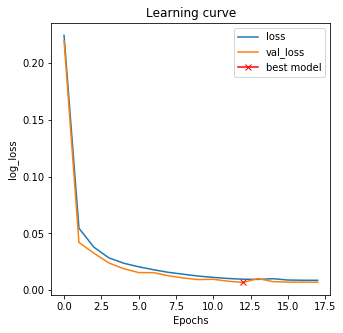

In [14]:
input_img = Input((IMAGE_SIZE, IMAGE_SIZE, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

weights_path = ROOT_PATH + '/dicty/weights/unet_bce_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

### dice

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 11s 288ms/step - loss: 0.9824 - acc: 0.8091 - val_loss: 0.9969 - val_acc: 0.0015

Epoch 00001: val_loss improved from inf to 0.99693, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_dice_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 138ms/step - loss: 0.9390 - acc: 0.9624 - val_loss: 0.9941 - val_acc: 0.7487

Epoch 00002: val_loss improved from 0.99693 to 0.99414, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_dice_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 137ms/step - loss: 0.7924 - acc: 0.9940 - val_loss: 0.9655 - val_acc: 0.9965

Epoch 00003: val_loss improved from 0.99414 to 0.96553, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_dice_corner_peak_half_step.h5
Epoch 4/100
39/39 [==============================] - 5s 137ms/step - loss: 0.6237 - acc: 0.9972 - val_loss: 0.9718 -

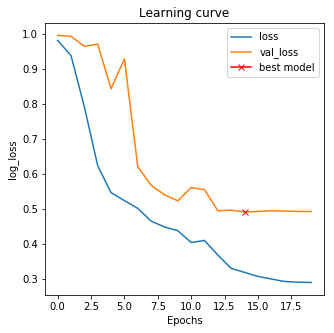

In [15]:
input_img = Input((IMAGE_SIZE, IMAGE_SIZE, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=['accuracy'])

weights_path = ROOT_PATH + '/dicty/weights/unet_dice_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

### bce-dice

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 13s 321ms/step - loss: 1.1727 - acc: 0.9765 - val_loss: 2.0192 - val_acc: 0.8956

Epoch 00001: val_loss improved from inf to 2.01918, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_dice_loss_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 140ms/step - loss: 1.0237 - acc: 0.9966 - val_loss: 1.0566 - val_acc: 0.9837

Epoch 00002: val_loss improved from 2.01918 to 1.05660, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_dice_loss_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 139ms/step - loss: 0.9594 - acc: 0.9947 - val_loss: 0.9819 - val_acc: 0.9954

Epoch 00003: val_loss improved from 1.05660 to 0.98195, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_bce_dice_loss_corner_peak_half_step.h5
Epoch 4/100
39/39 [==============================] - 5s 140ms/step - loss: 0.8742 - acc: 

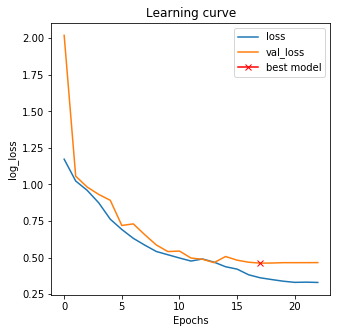

In [16]:
input_img = Input((IMAGE_SIZE, IMAGE_SIZE, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=['accuracy'])

weights_path = ROOT_PATH + '/dicty/weights/unet_bce_dice_loss_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

# RAO

In [0]:
X_train_rao = np.load(ROOT_PATH + '/rao/prepared_datasets/X_train.npy') 
X_test_rao = np.load(ROOT_PATH + '/rao/prepared_datasets/X_valid.npy')  
y_train_rao = np.load(ROOT_PATH + '/rao/prepared_datasets/y_train.npy') 
y_test_rao = np.load(ROOT_PATH + '/rao/prepared_datasets/y_valid.npy') 

### binary-crossentopy

Train on 2111 samples, validate on 218 samples
Epoch 1/100
2111/2111 [==============================] - 286s 136ms/step - loss: 0.0115 - acc: 0.9982 - val_loss: 0.0027 - val_acc: 0.9992

Epoch 00001: val_loss improved from inf to 0.00265, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_bce_corner_peak_half_step.h5
Epoch 2/100
2111/2111 [==============================] - 282s 134ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0023 - val_acc: 0.9993

Epoch 00002: val_loss improved from 0.00265 to 0.00230, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_bce_corner_peak_half_step.h5
Epoch 3/100
2111/2111 [==============================] - 283s 134ms/step - loss: 0.0016 - acc: 0.9995 - val_loss: 0.0022 - val_acc: 0.9993

Epoch 00003: val_loss improved from 0.00230 to 0.00222, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_bce_corner_peak_half_step.h5
Epoch 4/100
2111/2111 [==============================] - 283s 134ms/step - loss: 0.0015 - acc

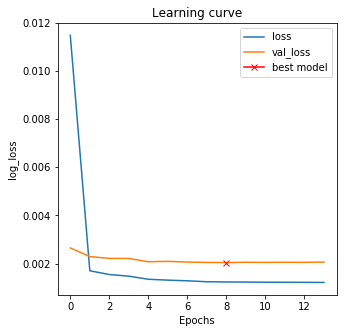

In [18]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

weights_path = ROOT_PATH + '/rao/weights/unet_RAO_bce_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train_rao, y_train_rao,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test_rao, y_test_rao))

plot_model_scores(results)

### dice

Train on 2111 samples, validate on 218 samples
Epoch 1/100
2111/2111 [==============================] - 288s 137ms/step - loss: 0.4875 - acc: 0.9953 - val_loss: 0.5184 - val_acc: 0.9992

Epoch 00001: val_loss improved from inf to 0.51841, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_dice_corner_peak_half_step.h5
Epoch 2/100
2111/2111 [==============================] - 279s 132ms/step - loss: 0.3969 - acc: 0.9994 - val_loss: 0.4049 - val_acc: 0.9992

Epoch 00002: val_loss improved from 0.51841 to 0.40494, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_dice_corner_peak_half_step.h5
Epoch 3/100
2111/2111 [==============================] - 280s 133ms/step - loss: 0.6541 - acc: 0.9993 - val_loss: 0.9350 - val_acc: 0.9990

Epoch 00003: val_loss did not improve from 0.40494
Epoch 4/100
2111/2111 [==============================] - 279s 132ms/step - loss: 0.8000 - acc: 0.9993 - val_loss: 0.9350 - val_acc: 0.9990

Epoch 00004: ReduceLROnPlateau reducing learning

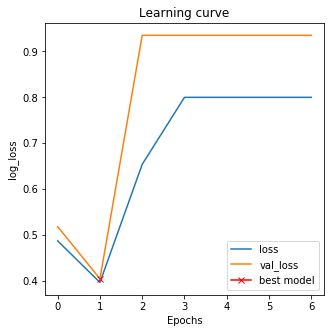

In [19]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=['accuracy'])

weights_path = ROOT_PATH + '/rao/weights/unet_RAO_dice_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train_rao, y_train_rao,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test_rao, y_test_rao))

plot_model_scores(results)

### bcd

In [20]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=['accuracy'])

weights_path = ROOT_PATH + '/rao/weights/unet_RAO_bce_dice_loss_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train_rao, y_train_rao,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test_rao, y_test_rao))


Train on 2111 samples, validate on 218 samples
Epoch 1/100
2111/2111 [==============================] - 291s 138ms/step - loss: 0.6224 - acc: 0.9989 - val_loss: 0.9515 - val_acc: 0.9990

Epoch 00001: val_loss improved from inf to 0.95154, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_bce_dice_loss_corner_peak_half_step.h5
Epoch 2/100
2111/2111 [==============================] - 280s 133ms/step - loss: 0.5705 - acc: 0.9993 - val_loss: 0.4122 - val_acc: 0.9992

Epoch 00002: val_loss improved from 0.95154 to 0.41219, saving model to gdrive/My Drive/HSE/loops/rao/weights/unet_RAO_bce_dice_loss_corner_peak_half_step.h5
Epoch 3/100
2111/2111 [==============================] - 281s 133ms/step - loss: 0.3933 - acc: 0.9994 - val_loss: 0.4147 - val_acc: 0.9993

Epoch 00003: val_loss did not improve from 0.41219
Epoch 4/100
2111/2111 [==============================] - 281s 133ms/step - loss: 0.3744 - acc: 0.9994 - val_loss: 0.3994 - val_acc: 0.9992

Epoch 00004: val_loss improved

# Transfer learning

### binary-crossentropy

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 15s 384ms/step - loss: 0.0067 - acc: 0.9980 - val_loss: 0.0054 - val_acc: 0.9986

Epoch 00001: val_loss improved from inf to 0.00543, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_bce_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 139ms/step - loss: 0.0056 - acc: 0.9982 - val_loss: 0.0040 - val_acc: 0.9987

Epoch 00002: val_loss improved from 0.00543 to 0.00398, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_bce_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 139ms/step - loss: 0.0049 - acc: 0.9983 - val_loss: 0.0040 - val_acc: 0.9987

Epoch 00003: val_loss did not improve from 0.00398
Epoch 4/100
39/39 [==============================] - 5s 139ms/step - loss: 0.0045 - acc: 0.9984 - val_loss: 0.0038 - val_acc: 0.9988

Epoch 00004: val_loss improved from 0.00398 to 0.00376, saving

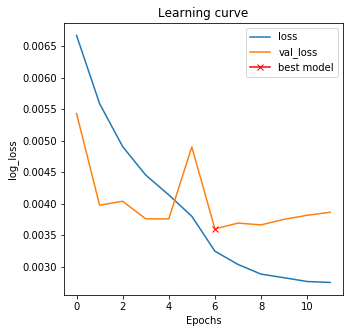

In [21]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

## load rao weights
model.load_weights(ROOT_PATH + '/rao/weights/unet_RAO_bce_corner_peak_half_step.h5')

weights_path = ROOT_PATH + '/dicty/weights/unet_transfer_bce_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

### dice

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 16s 406ms/step - loss: 0.7296 - acc: 0.9974 - val_loss: 0.6091 - val_acc: 0.9976

Epoch 00001: val_loss improved from inf to 0.60913, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_dice_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 138ms/step - loss: 0.6114 - acc: 0.9971 - val_loss: 0.5714 - val_acc: 0.9980

Epoch 00002: val_loss improved from 0.60913 to 0.57136, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_dice_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 136ms/step - loss: 0.5951 - acc: 0.9975 - val_loss: 0.5684 - val_acc: 0.9980

Epoch 00003: val_loss improved from 0.57136 to 0.56843, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_dice_corner_peak_half_step.h5
Epoch 4/100
39/39 [==============================] - 5s 137ms/step - loss: 0.5797 - acc: 

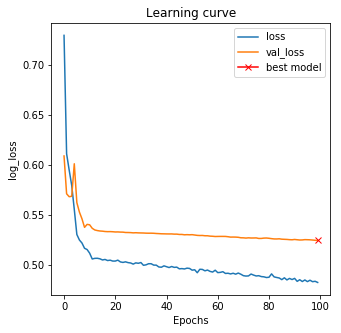

In [22]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=['accuracy'])

## load rao weights
model.load_weights(ROOT_PATH + '/rao/weights/unet_RAO_dice_corner_peak_half_step.h5')

weights_path = ROOT_PATH + '/dicty/weights/unet_transfer_dice_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

In [0]:
from sklearn.metrics import jaccard_similarity_score, jaccard_score

jaccard_similarity_score(y_test[index].reshape((256,256)), preds_test_t[index].reshape((256,256)))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.84375

### bce-dice

Train on 39 samples, validate on 14 samples
Epoch 1/100
39/39 [==============================] - 17s 434ms/step - loss: 0.6821 - acc: 0.9974 - val_loss: 0.6127 - val_acc: 0.9978

Epoch 00001: val_loss improved from inf to 0.61266, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_bce_dice_loss_corner_peak_half_step.h5
Epoch 2/100
39/39 [==============================] - 5s 140ms/step - loss: 0.6049 - acc: 0.9975 - val_loss: 0.6094 - val_acc: 0.9980

Epoch 00002: val_loss improved from 0.61266 to 0.60944, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_bce_dice_loss_corner_peak_half_step.h5
Epoch 3/100
39/39 [==============================] - 5s 138ms/step - loss: 0.5794 - acc: 0.9976 - val_loss: 0.5961 - val_acc: 0.9980

Epoch 00003: val_loss improved from 0.60944 to 0.59614, saving model to gdrive/My Drive/HSE/loops/dicty/weights/unet_transfer_bce_dice_loss_corner_peak_half_step.h5
Epoch 4/100
39/39 [==============================] - 5s 138ms/

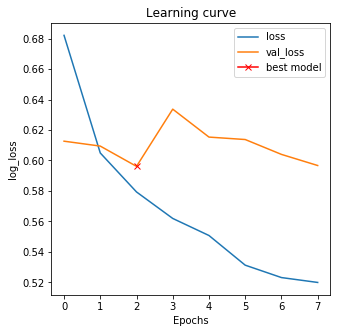

In [23]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=['accuracy'])

## load rao weights
model.load_weights(ROOT_PATH + '/rao/weights/unet_RAO_bce_dice_loss_corner_peak_half_step.h5')

weights_path = ROOT_PATH + '/dicty/weights/unet_transfer_bce_dice_loss_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

plot_model_scores(results)

# Predicted coordinates PoC

In [0]:
# Threshold predictions
t = 0.25
index = 1
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

im, contours, hierarchy = cv2.findContours(preds_test_t[index], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

In [0]:
Ms = []
i = 0
for contour in contours:
    M = cv2.moments(contour)
    if M['m00'] != 0:
        Mx = round(M['m10'] / M['m00'])
        My = round(M['m01'] / M['m00'])
        Ms.append((Mx, My))
    else:
        i += 1
        
print(i)

7


In [0]:
Ms

[(240, 246),
 (246, 239),
 (221, 236),
 (236, 222),
 (208, 214),
 (214, 208),
 (201, 195),
 (189, 196),
 (196, 189),
 (146, 153),
 (153, 147),
 (126, 136),
 (136, 126),
 (99, 104),
 (73, 81),
 (80, 74),
 (57, 72),
 (72, 57),
 (49, 57),
 (57, 49),
 (36, 48),
 (48, 36),
 (25, 36),
 (36, 25),
 (18, 24),
 (24, 18),
 (16, 6)]

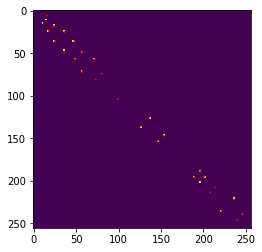

In [0]:
fig, ax = plt.subplots()
im = ax.imshow(np.zeros_like(preds_test_t[index]).reshape((256,256)))

circles = []
for point in Ms:
    ax.add_artist(plt.Circle(point, 0.5, color='r'))
    
plt.imshow(y_test[index].reshape((256,256)))

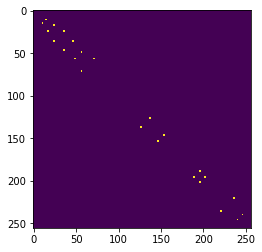

In [0]:
plt.imshow(y_test[index].reshape((256,256)))

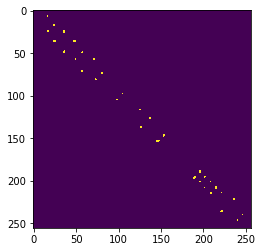

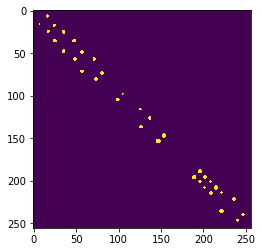

In [0]:
im1 = preds_test_t[index].copy()
plt.imshow(im1.reshape((256,256)))
plt.figure()


# cv2.drawContours(im1, contours, 0, (0, 255, 0), 2)
# plt.imshow(im1.reshape((256,256)))
# plt.figure()

canvas = np.zeros_like(im1.reshape((256,256)))
cv2.drawContours(canvas, contours, -1, (1, 0, 0), 2)
plt.imshow(canvas.reshape((256,256)))

# Models comparison

In [0]:
def unet(weight_path, loss):
    input_img = Input((IMAGE_SIZE, IMAGE_SIZE, 1), name='img')
    model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

    model.load_weights(weight_path)
    
    return model

In [0]:
def jaccard(pred, true):
    intersection = np.logical_and(pred, true)
    union = np.logical_or(pred, true)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

### Before transfer learning

In [37]:
model_bce = unet(ROOT_PATH + '/dicty/weights/unet_bce_corner_peak_half_step.h5', binary_crossentropy)

score, acc = model_bce.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_bce.predict(X_train, verbose=1)
preds_test = model_bce.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.006743737496435642
Test accuracy: 0.9984697699546814
14/14 [==============================] - 0s 22ms/step


0.2617056856187291

In [39]:
model_bcd = unet(ROOT_PATH + '/dicty/weights/unet_bce_dice_loss_corner_peak_half_step.h5', bce_dice_loss)

score, acc = model_bcd.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_bcd.predict(X_train, verbose=1)
preds_test = model_bcd.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.4687812626361847
Test accuracy: 0.9986321330070496
14/14 [==============================] - 0s 22ms/step


0.36210278540604157

In [40]:
model_dice = unet(ROOT_PATH + '/dicty/weights/unet_dice_corner_peak_half_step.h5', dice_coef_loss)

score, acc = model_dice.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_dice.predict(X_train, verbose=1)
preds_test = model_dice.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.504013180732727
Test accuracy: 0.9986114501953125
14/14 [==============================] - 0s 22ms/step


0.33738317757009345

### After transfer learning

In [38]:
model_transfer_bce = unet(ROOT_PATH + '/dicty/weights/unet_transfer_bce_corner_peak_half_step.h5', binary_crossentropy)

score, acc = model_transfer_bce.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_transfer_bce.predict(X_train, verbose=1)
preds_test = model_transfer_bce.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.0036005363799631596
Test accuracy: 0.9988141655921936
14/14 [==============================] - 0s 22ms/step


0.259851384823238

In [41]:
model_transfer_dice = unet(ROOT_PATH + '/dicty/weights/unet_transfer_dice_corner_peak_half_step.h5', dice_coef_loss)

score, acc = model_transfer_dice.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_transfer_dice.predict(X_train, verbose=1)
preds_test = model_transfer_dice.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.5325521230697632
Test accuracy: 0.9983760118484497
14/14 [==============================] - 0s 22ms/step


0.3076301978199435

In [34]:
model_transfer_bcd = unet(ROOT_PATH + '/dicty/weights/unet_transfer_bce_dice_loss_corner_peak_half_step.h5', bce_dice_loss)

score, acc = model_transfer_bcd.evaluate(X_test, y_test, verbose=0)

print('Test score:', score)
print('Test accuracy:', acc)

preds_train = model_transfer_bcd.predict(X_train, verbose=1)
preds_test = model_transfer_bcd.predict(X_test, verbose=1)

# Threshold predictions
t = 0.05
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

jaccard(preds_test_t, y_test)

Test score: 0.6010792851448059
Test accuracy: 0.998046875
14/14 [==============================] - 0s 23ms/step


0.25365521931315876

# Predict for full chromosome

#### utils

In [0]:
def predict_chromosome(model, x):
    '''
        predict mask шер loops for the whole chromosome
        input model and array
        return array with predicted probabilities
    '''
    x[np.isnan(x)] = 0
    x[x == -np.inf] = 0
    res = np.zeros_like(x)

    i = IMAGE_SIZE
    step = IMAGE_SIZE

    while i < x.shape[0]:
        start, end = i - step, i

        area = x[start:end, start:end]
        area = np.reshape(area, (1,IMAGE_SIZE,IMAGE_SIZE,1))

        pred = model.predict(area).reshape((IMAGE_SIZE, IMAGE_SIZE))
        pred = (pred + np.transpose(pred)) / 2
        res[start:end, start:end] = pred
        i += int(step / 2)

    i -= step

    # get the last part of an array
    if i < x.shape[0]:
        start, end = x.shape[0] - step, x.shape[0]
        
        area = x[start:end, start:end]
        area = np.reshape(area, (1,IMAGE_SIZE,IMAGE_SIZE,1))
        
        pred = model.predict(area).reshape((IMAGE_SIZE, IMAGE_SIZE))
        pred = (pred + np.transpose(pred)) / 2
        
        res[start:end, start:end] = pred
        
    return res

In [0]:
def get_coordinates(pred, threshold = 0.5):
    '''
        return coordinates of predicted areas and number of small areas
        for which it's impossible to find center
    '''
    pred_t = (pred > t).astype(np.uint8)
    pred_t = (pred > t).astype(np.uint8)

    im, contours, hierarchy = cv2.findContours(pred_t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    upper = []
    diagonal = []
    i = 0
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            Mx = round(M['m10'] / M['m00'])
            My = round(M['m01'] / M['m00'])
            if (Mx == My):
                diagonal.append((Mx, My))
            elif Mx < My:
                upper.append((Mx, My))
        else:
            i += 1
            
    return upper, diagonal, i

In [0]:
loops_info = pd.read_excel(ROOT_PATH + '/dicty_loop_positions_Chr1_Chr5_Chr6.xlsx')
loops_info['x'] = loops_info['x'].apply(lambda x: int(x - 1))
loops_info['y'] = loops_info['y'].apply(lambda x: int(x - 1))
chr6_real_coordinates = loops_info[loops_info['chr'] == 6]

In [0]:
def loops_prediction_stats(real, pred, near_threshold = 3):
    count_eq = 0
    count_near = 0
    count_none = 0
    for coordinate in pred:
        if (len(real[(real['x'] == coordinate[0]) & 
                     (real['y'] == coordinate[1])])):
            count_eq = count_eq + 1
            #print(coordinate)
        elif (len(real[((real['x'] >= coordinate[0] - near_threshold) &(real['x'] <= coordinate[0] + near_threshold)) & 
                       ((real['y'] >= coordinate[1] - near_threshold) & (real['y'] <= coordinate[1] + near_threshold))])):
            count_near = count_near + 1
            #print('Near', coordinate)
        else:
            count_none = count_none + 1
            
            
    return count_eq, count_near, count_none

#### models comparison

In [234]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_bce, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  0
Above diagonal:		  26
Equal:			  3
Near:			  20
Not found:		  3
Total:			  93


In [235]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_dice, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  0
Above diagonal:		  78
Equal:			  15
Near:			  50
Not found:		  13
Total:			  93


In [236]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_bcd, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  1
Above diagonal:		  97
Equal:			  12
Near:			  63
Not found:		  22
Total:			  93


In [237]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_transfer_bce, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  1
Above diagonal:		  117
Equal:			  12
Near:			  69
Not found:		  36
Total:			  93


In [238]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_transfer_dice, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  29
Above diagonal:		  81
Equal:			  12
Near:			  49
Not found:		  20
Total:			  93


In [239]:
chr6 = np.load(ROOT_PATH + '/arrs/2kb_chr6_norm.npy')
pred = predict_chromosome(model_transfer_bcd, chr6)
c, d, i = get_coordinates(pred)

print('On diagonal:\t\t ',  len(d))
print('Above diagonal:\t\t ', len(c))

count_eq, count_near, count_none = loops_prediction_stats(chr6_real_coordinates, c)

print('Equal:\t\t\t ', count_eq)
print('Near:\t\t\t ', count_near)
print('Not found:\t\t ', count_none)

print('Total:\t\t\t ', len(chr6_real_coordinates))

On diagonal:		  57
Above diagonal:		  85
Equal:			  12
Near:			  50
Not found:		  23
Total:			  93
